# What's the best way to predict solar radiation levels?

Solar radiation is energy emitted by the sun from a nuclear fusion reaction. It can be captured and converted into energy. It is important to us because it is a clean and renewable energy source. The ability to predict the levels in a particular location is an essential part of the decision making process when building solar energy farms.

Solar radiation levels depend on:

* Geographic location
* Time of day
* Season
* Local landscape
* Local weather

With this is mind, which supervised learning model is the best for predicting solar radiation levels?

# Import libraries & load the dataset

The data used in this project was collected at the HI-SEAS weather station in Hawaii from September 2016 to January 2017.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_validate

In [2]:
df=pd.read_csv("/Users/melineminassian/Downloads/SolarPrediction.csv")

# Cleaning & Exploration

In [3]:
df.shape

(32686, 11)

In [4]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
df.dtypes

UNIXTime                    int64
Data                       object
Time                       object
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
TimeSunRise                object
TimeSunSet                 object
dtype: object

Convert date type, reformat and rename column

In [6]:
df["Data"] = pd.to_datetime(df["Data"])
df["Data"] = df["Data"].dt.strftime('%d-%m-%Y')
df = df.rename(columns = {"Data":"Date"}) 

Add column hour, month, year and duration of day

No longer need date,  time, time_conv, timesunrise or timesunset so drop

In [7]:
df["Time_Conv"] =  pd.to_datetime(df["Time"], format='%H:%M:%S')
df["Hour"] = pd.to_datetime(df["Time_Conv"], format='%H:%M:%S').dt.hour
df["Month"] = pd.to_datetime(df["UNIXTime"].astype(int), unit='s').dt.month
df["Year"] = pd.to_datetime(df["UNIXTime"].astype(int), unit='s').dt.year
df["Total_Time"] = pd.to_datetime(df["TimeSunSet"], format='%H:%M:%S').dt.hour - pd.to_datetime(
    df['TimeSunRise'], format='%H:%M:%S').dt.hour

df.drop(["Date", "Time", "TimeSunRise", "TimeSunSet", "Time_Conv"], axis=1, inplace=True)
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
0,1475229326,1.21,48,30.46,59,177.39,5.62,23,9,2016,12
1,1475229023,1.21,48,30.46,58,176.78,3.37,23,9,2016,12
2,1475228726,1.23,48,30.46,57,158.75,3.37,23,9,2016,12
3,1475228421,1.21,48,30.46,60,137.71,3.37,23,9,2016,12
4,1475228124,1.17,48,30.46,62,104.95,5.62,23,9,2016,12


In [8]:
df.dtypes

UNIXTime                    int64
Radiation                 float64
Temperature                 int64
Pressure                  float64
Humidity                    int64
WindDirection(Degrees)    float64
Speed                     float64
Hour                        int64
Month                       int64
Year                        int64
Total_Time                  int64
dtype: object

In [9]:
df.head()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
0,1475229326,1.21,48,30.46,59,177.39,5.62,23,9,2016,12
1,1475229023,1.21,48,30.46,58,176.78,3.37,23,9,2016,12
2,1475228726,1.23,48,30.46,57,158.75,3.37,23,9,2016,12
3,1475228421,1.21,48,30.46,60,137.71,3.37,23,9,2016,12
4,1475228124,1.17,48,30.46,62,104.95,5.62,23,9,2016,12


Check for missing data - there is none!

In [10]:
df.isna().sum()

UNIXTime                  0
Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Hour                      0
Month                     0
Year                      0
Total_Time                0
dtype: int64

We can see here that there are outlisers in the radiation column.

Most of the data is under 355 W/m^2

In [11]:
round(df.describe())

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
count,3.268600e+04,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0,32686.0
mean,1.478047e+09,207.0,51.0,30.0,75.0,143.0,6.0,12.0,10.0,2016.0,11.0
std,3.005037e+06,316.0,6.0,0.0,26.0,83.0,3.0,7.0,1.0,0.0,0.0
min,1.472724e+09,1.0,34.0,30.0,8.0,0.0,0.0,0.0,1.0,2016.0,11.0
25%,1.475546e+09,1.0,46.0,30.0,56.0,82.0,3.0,6.0,10.0,2016.0,11.0
50%,1.478026e+09,3.0,50.0,30.0,85.0,148.0,6.0,12.0,11.0,2016.0,11.0
75%,1.480480e+09,354.0,55.0,30.0,97.0,179.0,8.0,18.0,11.0,2016.0,12.0
max,1.483265e+09,1601.0,71.0,31.0,103.0,360.0,40.0,23.0,12.0,2017.0,12.0


In [12]:
df.Radiation.value_counts()

1.22       2264
1.23       2110
1.21       2010
1.24       1725
1.20       1558
           ... 
601.96        1
658.63        1
108.51        1
1040.07       1
322.68        1
Name: Radiation, Length: 14434, dtype: int64

Remove rows where radiation is over 500. This is around 6000 rows.

In [13]:
df = df[df["Radiation"] < 500]

In [14]:
round(df.describe())

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
count,2.640900e+04,26409.0,26409.0,26409.0,26409.0,26409.0,26409.0,26409.0,26409.0,26409.0,26409.0
mean,1.478129e+09,68.0,49.0,30.0,78.0,151.0,6.0,12.0,11.0,2016.0,11.0
std,3.045428e+06,128.0,5.0,0.0,25.0,73.0,3.0,8.0,1.0,0.0,0.0
min,1.472724e+09,1.0,34.0,30.0,8.0,0.0,0.0,0.0,1.0,2016.0,11.0
25%,1.475567e+09,1.0,46.0,30.0,62.0,112.0,3.0,4.0,10.0,2016.0,11.0
50%,1.478147e+09,1.0,48.0,30.0,89.0,156.0,6.0,12.0,11.0,2016.0,11.0
75%,1.480765e+09,56.0,52.0,30.0,99.0,181.0,8.0,19.0,12.0,2016.0,12.0
max,1.483265e+09,500.0,70.0,31.0,103.0,360.0,38.0,23.0,12.0,2017.0,12.0


In [15]:
df.shape

(26409, 11)

### Correlation

1. Nothing over 90%
2. Significant correlation between radiation & temperature

In [16]:
corr_matrix = df.corr()
corr_matrix

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
UNIXTime,1.000000,-0.018351,-0.428263,-0.348170,-0.087745,0.167282,0.184761,-0.004569,0.784590,0.110169,-0.825456
Radiation,-0.018351,1.000000,0.540100,0.006361,0.027095,-0.179500,-0.010711,0.015513,-0.022469,-0.001593,0.021763
Temperature,-0.428263,0.540100,1.000000,0.304900,-0.057524,-0.226110,-0.124935,0.280043,-0.332612,-0.038460,0.381117
Pressure,-0.348170,0.006361,0.304900,1.000000,-0.193913,-0.231035,-0.052384,0.123662,-0.247087,-0.118181,0.167463
Humidity,-0.087745,0.027095,-0.057524,-0.193913,1.000000,-0.076749,-0.246374,0.082576,-0.089913,0.021150,0.157457
WindDirection(Degrees),0.167282,-0.179500,-0.226110,-0.231035,-0.076749,1.000000,0.114566,-0.096452,0.105504,0.110119,-0.084603
Speed,0.184761,-0.010711,-0.124935,-0.052384,-0.246374,0.114566,1.000000,-0.077006,0.119943,0.035194,-0.178051
Hour,-0.004569,0.015513,0.280043,0.123662,0.082576,-0.096452,-0.077006,1.000000,-0.041207,0.061582,0.014902
Month,0.784590,-0.022469,-0.332612,-0.247087,-0.089913,0.105504,0.119943,-0.041207,1.000000,-0.490766,-0.665131
Year,0.110169,-0.001593,-0.038460,-0.118181,0.021150,0.110119,0.035194,0.061582,-0.490766,1.000000,-0.047332


In [17]:
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
to_drop

[]

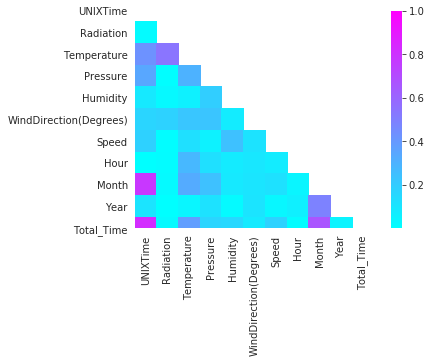

In [18]:
#sns.heatmap(corr_matrix, cmap="BuPu")

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    p2 = sns.heatmap(corr_matrix, mask=mask, square=True, cmap='cool')


# Visualisations

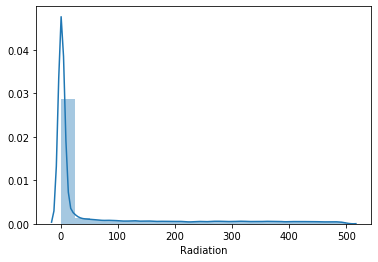

In [19]:
sns.distplot(df["Radiation"], bins=20)

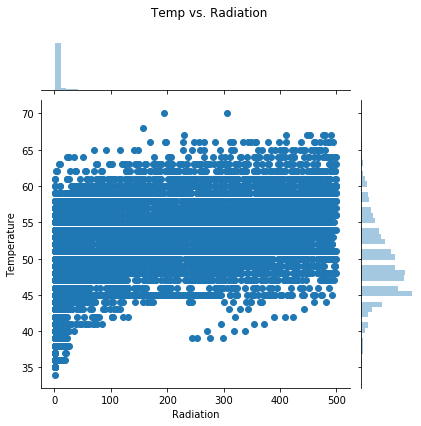

In [20]:
g = sns.jointplot(x="Radiation", y="Temperature", data=df)
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Temp vs. Radiation');

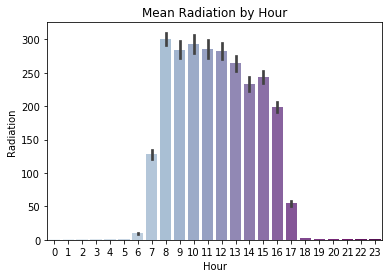

In [21]:
ax = plt.axes()
sns.barplot(x="Hour", y='Radiation', data=df, palette="BuPu", ax = ax)
ax.set_title("Mean Radiation by Hour")
plt.show()

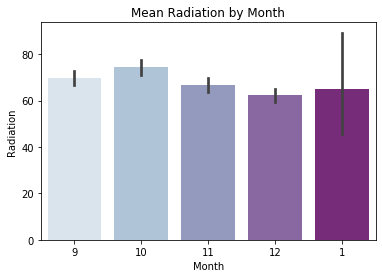

In [22]:
ax = plt.axes()
sns.barplot(x="Month", y="Radiation", data=df, palette="BuPu", ax = ax, order=[9,10,11,12,1])
ax.set_title("Mean Radiation by Month")
plt.show()

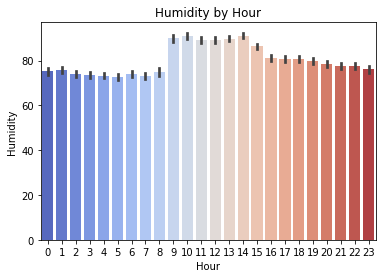

In [23]:
ax = plt.axes()
sns.barplot(x="Hour", y='Humidity', data=df, palette=("coolwarm"), ax = ax)
ax.set_title("Humidity by Hour")
plt.show()

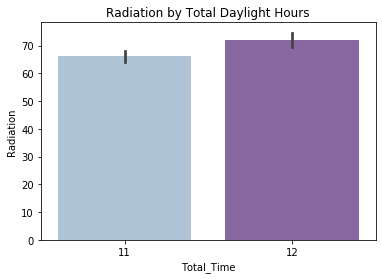

In [24]:
ax = plt.axes()
sns.barplot(x="Total_Time", y='Radiation', data=df, palette="BuPu", ax = ax)
ax.set_title("Radiation by Total Daylight Hours")
plt.show()

# Supervised Learning

###### Let's build different prediction models and test which one is the best

## Linear Regression

In [25]:
df.head(5)

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Hour,Month,Year,Total_Time
0,1475229326,1.21,48,30.46,59,177.39,5.62,23,9,2016,12
1,1475229023,1.21,48,30.46,58,176.78,3.37,23,9,2016,12
2,1475228726,1.23,48,30.46,57,158.75,3.37,23,9,2016,12
3,1475228421,1.21,48,30.46,60,137.71,3.37,23,9,2016,12
4,1475228124,1.17,48,30.46,62,104.95,5.62,23,9,2016,12


In [26]:
X_train,  X_test, y_train, y_test = train_test_split(df.drop(columns="Radiation", axis=1),
                                                     df.Radiation, test_size=0.33, random_state=42)

In [27]:
linear_model = LinearRegression().fit(X_train, y_train)
y_test_pred = linear_model.predict(X_test)
y_test_pred

array([-24.2782305 ,   0.47908612, -10.24239065, ...,   8.08148444,
        46.35730663,  27.34743056])

In [28]:
A_vs_P = pd.DataFrame(columns=["Prediction", "Actual"])
A_vs_P['Prediction'] = y_test_pred
A_vs_P['Actual'] = list(y_test)

A_vs_P["Difference"] = A_vs_P['Prediction'] - A_vs_P['Actual']
round(A_vs_P, 2).head(10)
print("Average difference = ", round(A_vs_P["Difference"].mean(),2))

Average difference =  1.84


Intercept = the expected mean value of Y when all X=0

Coefficient/Slope = the % increase of radiation for each change in a parameter

In [31]:
print("Intercept = " + str(linear_model.intercept_))
coeffecients = pd.DataFrame(linear_model.coef_,X_test.columns)
coeffecients.columns = ["Coeffecient"]
coeffecients

Intercept = 613041.5394654104


,Coeffecient
UNIXTime,0.000019
Temperature,19.658248
Pressure,-272.549363
Humidity,0.485109
WindDirection(Degrees),-0.151634
Speed,1.370309
Hour,-3.205362
Month,-27.843678
Year,-313.853764
Total_Time,-19.537443


1. R squared is a statistical measure of how close the data are to the fitted regression line. The closer to 1 the better.
2. Mean Absolute Error is the distance between data points and the line. The lower the better.
3. Mean Squared Error is the square of the distance between data points and the line. The lower the better.
4. Root Mean Squared Error is the square root of MSE. The lower the better.

In [32]:
scoretest = r2_score(y_test, y_test_pred)
print("R-squared is ", scoretest)
mae = mean_absolute_error(y_test, y_test_pred)
print("MAE is:", mae)
mse = mean_squared_error(y_test, y_test_pred)
print("MSE is:", mse)
rmse = np.sqrt(mse)
print("RMSE is", rmse)

R-squared is  0.41405488948749347
MAE is: 72.16992779899317
MSE is: 9589.209889926897
RMSE is 97.92451118043377


## Linear regression 2

In [33]:
X_train1,  X_test1, y_train1, y_test1 = train_test_split(df.drop(columns="Radiation", axis=1),
                                                     df.Radiation, test_size=0.33, random_state=101)

Building a step forward feature selection

k_features selects top 8 columns most significant to achieve the target

In [34]:
linear = LinearRegression()
sfs1 = sfs(linear, k_features = 8, forward=True, floating=False, scoring="neg_mean_squared_error")
sfs1 = sfs1.fit(X_train1, y_train1)
sfs1.k_feature_idx_

(0, 1, 2, 3, 4, 5, 6, 9)

These are the column numbers that are highly significant to achieve the target

In [35]:
feat_cols = list(sfs1.k_feature_idx_)
print(feat_cols)

[0, 1, 2, 3, 4, 5, 6, 9]


In [36]:
linear_model_2 = LinearRegression().fit(X_train1.iloc[:,feat_cols], y_train1)
y_test_pred1 = linear_model_2.predict(X_test1.iloc[:,feat_cols])

In [37]:
linear_model_2

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [38]:
A_vs_P1 = pd.DataFrame([y_test_pred1, y_test1]).T
A_vs_P1

A_vs_P1 = pd.DataFrame(columns=["Prediction", "Actual"])
A_vs_P1['Prediction'] = y_test_pred1
A_vs_P1['Actual'] = list(y_test1)

A_vs_P1["Difference"] = A_vs_P1['Prediction'] - A_vs_P1['Actual']
round(A_vs_P1, 2).head(10)
print("Average difference = ", round(A_vs_P1["Difference"].mean(),2))

Average difference =  1.01


In [39]:
scoretest1 = r2_score(y_test1, y_test_pred1)
print("R-squared is ", scoretest1)
mae1 = mean_absolute_error(y_test1, y_test_pred1)
print("MAE is:", mae1)
mse1 = mean_squared_error(y_test1, y_test_pred1)
print("MSE is:", mse1)
rmse1 = np.sqrt(mse1)
print("RMSE is", rmse1)

R-squared is  0.41236347244435057
MAE is: 71.93226357976967
MSE is: 9685.542565816912
RMSE is 98.41515414719885


## Decision Tree

In [40]:
X_train2,  X_test2, y_train2, y_test2 = train_test_split(df.drop(columns="Radiation", axis=1),
                                                     df.Radiation, test_size=0.33, random_state=101)

In [41]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train2, y_train2)
y_test_pred2 = tree_model.predict(X_test2)

In [42]:
scoretest2 = r2_score(y_test2, y_test_pred2)
print("R-squared is ", scoretest2)
mae2 = mean_absolute_error(y_test2, y_test_pred2)
print("MAE is:", mae2)
mse2 = mean_squared_error(y_test2, y_test_pred2)
print("MSE is:", mse2)
rmse2 = np.sqrt(mse2)
print("RMSE is", rmse2)

R-squared is  0.826004670600647
MAE is: 20.498981067125644
MSE is: 2867.825756442915
RMSE is 53.552084520053135


## Random Forest

In [44]:
X_train3,  X_test3, y_train3, y_test3 = train_test_split(df.drop(columns="Radiation", axis=1),
                                                     df.Radiation, test_size=0.33, random_state=101)

In [45]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train3, y_train3)
y_test_pred3 = rf_model.predict(X_test3)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [46]:
scoretest3 = r2_score(y_test3, y_test_pred3)
print("R-squared is ", scoretest3)
mae3 = mean_absolute_error(y_test3, y_test_pred3)
print("MAE is:", mae3)
mse3 = mean_squared_error(y_test3, y_test_pred3)
print("MSE is:", mse3)
rmse3 = np.sqrt(mse3)
print("RMSE is", rmse3)

R-squared is  0.8964293002321663
MAE is: 17.12497532989099
MSE is: 1707.0729509370053
RMSE is 41.31673935509681


# K Nearest Neighbours

In [48]:
X_train4,  X_test4, y_train4, y_test4 = train_test_split(df.drop(columns="Radiation", axis=1),
                                                     df.Radiation, test_size=0.33, random_state=101)

In [49]:
k_model = KNeighborsRegressor()
k_model.fit(X_train4, y_train4)
y_test_pred4 = k_model.predict(X_test4)

In [50]:
scoretest4 = r2_score(y_test4, y_test_pred4)
print("R-squared is ", scoretest4)
mae4 = mean_absolute_error(y_test4, y_test_pred4)
print("MAE is:", mae4)
mse4 = mean_squared_error(y_test4, y_test_pred4)
print("MSE is:", mse4)
rmse4 = np.sqrt(mse4)
print("RMSE is", rmse4)

R-squared is  0.9247003215118724
MAE is: 13.56962662076879
MSE is: 1241.1043340392428
RMSE is 35.22931072330599


# Model Comparison

We can see here that the K Nearest Neighbour algorithm is the best for predicting solar radiation and it has the highest R-squared score and the lowest Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

In [51]:
df2 = pd.DataFrame({
    "Model": ["Linear Regression1", "Linear Regression2", "Decision Tree", "Random Forest","K Nearest Neighbour",
              "Average"],
    "R2": [scoretest*100, scoretest1*100, scoretest2*100, scoretest3*100, scoretest4*100,
           ((scoretest+scoretest1+scoretest2+scoretest3+scoretest4)/5)*100],
    "MAE": [mae, mae1, mae2, mae3, mae4, ((mae+mae1+mae2+mae3+mae4)/5)],
    "MSE": [mse, mse1, mse2, mse3, mse4, ((mse+mse1+mse2+mse3+mse4)/5)],
    "RMSE": [rmse, rmse1, rmse2, rmse3, rmse4, ((rmse+rmse1+rmse2+rmse3+rmse4)/5)],
})
round(df2, 2)

,Model,R2,MAE,MSE,RMSE
0,Linear Regression1,41.41,72.17,9589.21,97.92
1,Linear Regression2,41.24,71.93,9685.54,98.42
2,Decision Tree,82.60,20.50,2867.83,53.55
3,Random Forest,89.64,17.12,1707.07,41.32
4,K Nearest Neighbour,92.47,13.57,1241.10,35.23
5,Average,69.47,39.06,5018.15,65.29


# Ensemble Algorithm

We have found the best algorithm for predicting solar radiation but we can make strengthen the accuracy of our predictions by combining our algorithms in an ensemble algorithm.

Ensemble algorithms average out bias, reduce variance and are make overfitting unlikely. This produces better predictions!

In [52]:
#create a dictionary of our models
estimators=[("k_model", k_model), ("rf_model", rf_model), ("tree_model", tree_model), 
            ("linear_model_2", linear_model_2), ("linear_model", linear_model)]
#create our voting classifier, inputting our models
ensemble = VotingRegressor(estimators)

In [53]:
ensemble.fit(X_train4, y_train4)

VotingRegressor(estimators=[('k_model',
                             KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                                 metric='minkowski',
                                                 metric_params=None,
                                                 n_jobs=None, n_neighbors=5,
                                                 p=2, weights='uniform')),
                            ('rf_model',
                             RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                

In [54]:
ensemble_r = (ensemble.score(X_test4, y_test4)*100)
ensemble_r

83.41789775229618

The R-Squared score is good! But can we improve it by using only the top 3 algorithms?

In [55]:
estimators2=[("k_model", k_model), ("rf_model", rf_model), ("tree_model", tree_model)]
ensemble2 = VotingRegressor(estimators2)

In [56]:
ensemble2.fit(X_train4, y_train4)
ensemble2_r = (ensemble2.score(X_test4, y_test4)*100)
ensemble2_r

91.61200921389998

The R-Squared  score is even better! But let's compare all scores before making any decisions.

In [57]:
df2 = pd.DataFrame({
    "Model": ["Linear Regression1", "Linear Regression2", "Decision Tree", "Random Forest","K Nearest Neighbour",
              "Average"],
    "R2": [scoretest*100, scoretest1*100, scoretest2*100, scoretest3*100, scoretest4*100,
           ((scoretest+scoretest1+scoretest2+scoretest3+scoretest4)/5)*100],
    "MAE": [mae, mae1, mae2, mae3, mae4, ((mae+mae1+mae2+mae3+mae4)/5)],
    "MSE": [mse, mse1, mse2, mse3, mse4, ((mse+mse1+mse2+mse3+mse4)/5)],
    "RMSE": [rmse, rmse1, rmse2, rmse3, rmse4, ((rmse+rmse1+rmse2+rmse3+rmse4)/5)],
})
round(df2, 2)

,Model,R2,MAE,MSE,RMSE
0,Linear Regression1,41.41,72.17,9589.21,97.92
1,Linear Regression2,41.24,71.93,9685.54,98.42
2,Decision Tree,82.60,20.50,2867.83,53.55
3,Random Forest,89.64,17.12,1707.07,41.32
4,K Nearest Neighbour,92.47,13.57,1241.10,35.23
5,Average,69.47,39.06,5018.15,65.29


In [58]:
df3 = pd.DataFrame({
    "Model": ["Linear Regression1", "Linear Regression2", "Decision Tree", "Random Forest","K Nearest Neighbour",
              "Average", "Ensemble", "Ensemble2"],
    "R2": [scoretest*100, scoretest1*100, scoretest2*100, scoretest3*100, scoretest4*100,
           ((scoretest+scoretest1+scoretest2+scoretest3+scoretest4)/5)*100, ensemble_r, ensemble2_r]
})
round(df3, 2)

,Model,R2
0,Linear Regression1,41.41
1,Linear Regression2,41.24
2,Decision Tree,82.60
3,Random Forest,89.64
4,K Nearest Neighbour,92.47
5,Average,69.47
6,Ensemble,83.42
7,Ensemble2,91.61


# Testing the K Nearest neighbour Algorithm

Let's test the algorithm with the current weather conditions in London, England

In [86]:
import time
import datetime
now = datetime.datetime.now()

In [95]:
columns = ['UNIXTime', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'Hour', 'Month', 'Year',
       'Total_Time']
london_dict = {'UNIXTime':time.time(), 'Temperature':50, 'Pressure':30.23, 'Humidity':74,
       'WindDirection':211.62, 'Speed':12, 'Hour':now.hour, 'Month':now.month, 'Year':now.year, 'Total_Time':8}
test_london = pd.DataFrame([london_dict], columns=london_dict.keys())

In [96]:
pred_Test_london = k_model.predict(test_london)
print("The predicted solar radiation level in London is " + str(pred_Test_london) + ".")

The predicted solar radiation level in London is [1.206].


London's solar radiation levels usually fall between 0.52 and 4.74 so this prediction is plausible!

# Testing the Ensemble 2 Algorithm

In [106]:
columns = ['UNIXTime', 'Temperature', 'Pressure', 'Humidity',
       'WindDirection(Degrees)', 'Speed', 'Hour', 'Month', 'Year',
       'Total_Time']
london_dict2 = {'UNIXTime':time.time(), 'Temperature':50, 'Pressure':30.23, 'Humidity':74,
       'WindDirection':211.62, 'Speed':12, 'Hour':now.hour, 'Month':now.month, 'Year':now.year, 'Total_Time':8}
test_london2 = pd.DataFrame([london_dict2], columns=london_dict2.keys())

In [111]:
pred_Test_london2 = ensemble2.predict(test_london2)
print("The predicted solar radiation level in London is " + str(pred_Test_london2) + ".")

The predicted solar radiation level in London is [68.17].


The prediction here is not so good! 

# Conclusion

We can see that K Nearest Neighbour still has the best R-Squared score making it the stronger algorithm. The prediction that this model made is possible.

The ensemble algorithms average out bias, reduce variance and make overfitting unlikely but the second one (combination of 3 strongest algorithms) did not make a good prediction.

It would b e best to use the K Nearest neighbout algorithm for future predictions.